In [1]:
import cv2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

c:\Users\Legion\.conda\envs\tf26\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = tfds.load('horses_or_humans', split='train[:75%]', as_supervised=True)
validation_data = tfds.load('horses_or_humans', split='train[75%:90%]', as_supervised=True)
test_data = tfds.load('horses_or_humans', split='train[-10%:]', as_supervised=True)

In [3]:
def augment_images(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/255.0)
    image = tf.image.resize(image,(300,300))
    return image, label

augmented_training_data = train_data.map(augment_images)
train_batches = augmented_training_data.shuffle(100).batch(16)

augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.shuffle(100).batch(16)

augment_validation_data = validation_data.map(augment_images)
validation_batches = augment_validation_data.shuffle(100).batch(16)

In [4]:
def plot_history(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2 ,1)
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2 ,2)
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

In [5]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

Epoch 1/50
49/49 [==============================] - 5s 40ms/step - loss: 0.6859 - accuracy: 0.5377 - val_loss: 0.7012 - val_accuracy: 0.4416
Epoch 2/50
49/49 [==============================] - 1s 29ms/step - loss: 0.6130 - accuracy: 0.6390 - val_loss: 0.6432 - val_accuracy: 0.6364
Epoch 3/50
49/49 [==============================] - 1s 29ms/step - loss: 0.4981 - accuracy: 0.7558 - val_loss: 0.4531 - val_accuracy: 0.7792
Epoch 4/50
49/49 [==============================] - 1s 30ms/step - loss: 0.4337 - accuracy: 0.7948 - val_loss: 0.3483 - val_accuracy: 0.8636
Epoch 5/50
49/49 [==============================] - 1s 29ms/step - loss: 0.3712 - accuracy: 0.8143 - val_loss: 0.3153 - val_accuracy: 0.8636
Epoch 6/50
49/49 [==============================] - 1s 30ms/step - loss: 0.2805 - accuracy: 0.8792 - val_loss: 0.2170 - val_accuracy: 0.9091
Epoch 7/50
49/49 [==============================] - 1s 29ms/step - loss: 0.2569 - accuracy: 0.8909 - val_loss: 0.3397 - val_accuracy: 0.8312
Epoch 8/50
49

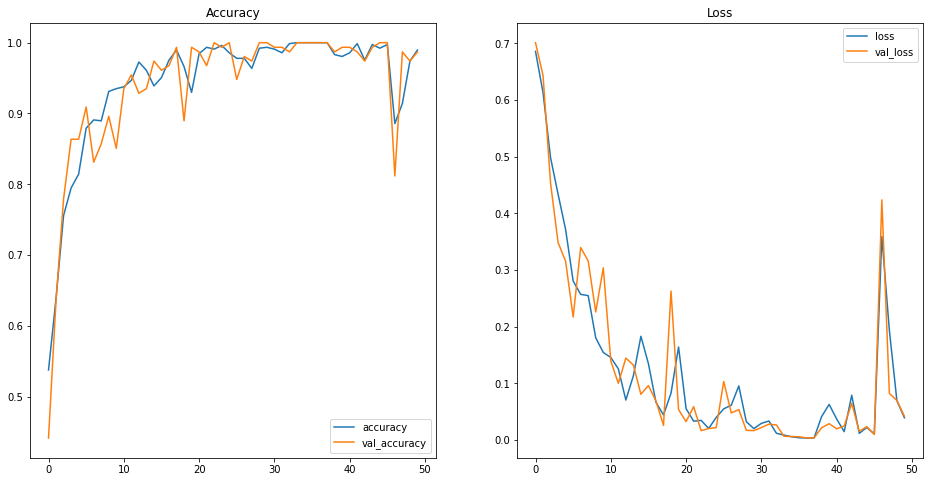

In [6]:
model.compile(
            loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer='adam'
            )
history = model.fit(
                train_batches,
                validation_data=validation_batches,
                epochs=50
                )
plot_history(history)

In [7]:
cam_model  = Model(
                inputs=model.input,
                outputs=(
                        model.layers[-3].output, # Last convolutional layer
                        model.layers[-1].output  # Output Layer
                        ))
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

In [8]:
output_layer = model.layers[-1]
gap_weights_l = output_layer.get_weights()
print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

gap_weights = gap_weights_l[0] #only store Store the weights
print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 1)
gap_weights_l index 1 contains biases  (1,)
There are 128 feature weights and 1 classes.


In [25]:
def test_on_batch(single_batch_inputs, single_batch_labels, single_batch_features, single_batch_predictions):
    for idx in range(len(single_batch_inputs)):
        img = single_batch_inputs[idx]
        class_true = single_batch_labels[idx]

        class_pred = int(np.round(single_batch_predictions[idx]).squeeze())
        img_feature = single_batch_features[idx, :] # (37, 37, 128)

        img_feature_scaled = sp.ndimage.zoom(img_feature, (300/37, 300/37,1), order=2) # (300, 300, 128)

        gap_weights_for_one_class = gap_weights[:,0] # (128,) 
        cam_output = np.dot(img_feature_scaled, gap_weights_for_one_class) # (300, 300)
        
        if class_true == 1:
            if single_batch_predictions[idx].squeeze() > 0.95: # if the predicted class is very likely
                cmap_str = 'Greens'
            else:                             # if the predicted class is not very likely
                cmap_str = 'Reds'

        else:
            if single_batch_predictions[idx].squeeze() < 0.05:
                cmap_str = 'Blues'
            else:
                cmap_str = 'Reds'

        print(f"class_true: {class_true}, class_pred: {class_pred}, likelihood: {single_batch_predictions[idx].squeeze()}")
        plt.imshow(img, alpha=0.5)
        plt.imshow(cam_output, cmap=cmap_str, alpha=0.5) # Overlay CAM on the original image
        plt.show()


In [26]:
single_batch = single_batch = test_batches.as_numpy_iterator().__next__()
single_batch_inputs = single_batch[0]
single_batch_labels = single_batch[1] 
print(f"single_batch_inputs shape: {single_batch_inputs.shape}")
print(f"single_batch_labels shape: {single_batch_labels.shape}")

single_batch_inputs shape: (16, 300, 300, 3)
single_batch_labels shape: (16,)


In [27]:
single_batch_features, single_batch_predictions = cam_model.predict(single_batch_inputs)
print(f"features shape: {single_batch_features.shape}")
print(f"classes shape: {single_batch_predictions.shape}")

features shape: (16, 37, 37, 128)
classes shape: (16, 1)


class_true: 1, class_pred: 1, likelihood: 1.0


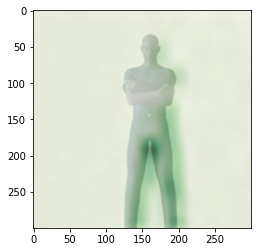

class_true: 1, class_pred: 1, likelihood: 1.0


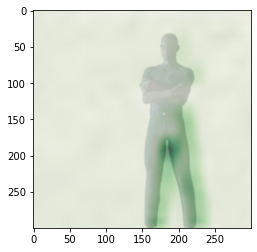

class_true: 1, class_pred: 1, likelihood: 1.0


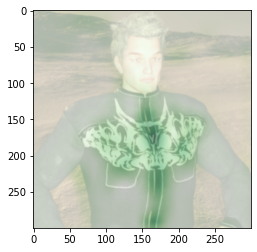

class_true: 1, class_pred: 1, likelihood: 0.9929224252700806


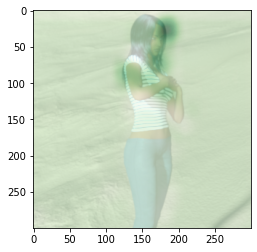

class_true: 1, class_pred: 1, likelihood: 0.6291189193725586


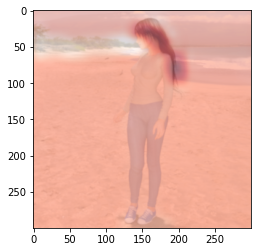

class_true: 0, class_pred: 0, likelihood: 0.0033711993601173162


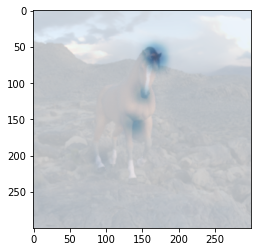

class_true: 0, class_pred: 0, likelihood: 7.327872086904108e-09


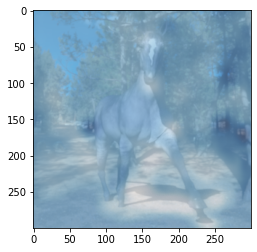

class_true: 1, class_pred: 1, likelihood: 0.8504358530044556


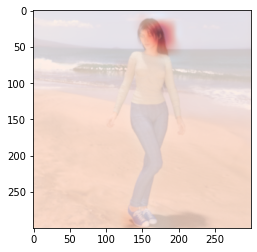

class_true: 0, class_pred: 0, likelihood: 4.0568610870650446e-07


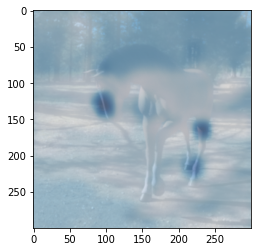

class_true: 0, class_pred: 0, likelihood: 2.3554125760938405e-08


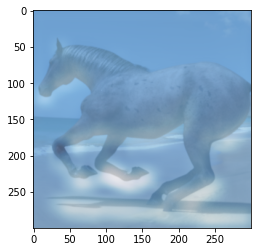

class_true: 0, class_pred: 0, likelihood: 0.0011803809320554137


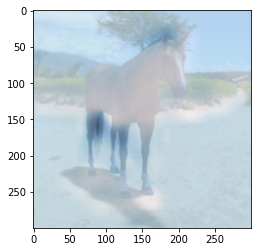

class_true: 1, class_pred: 1, likelihood: 0.780380129814148


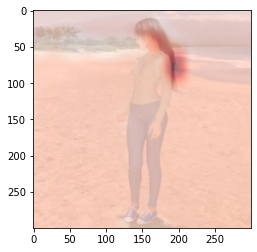

class_true: 0, class_pred: 0, likelihood: 5.810174479847774e-05


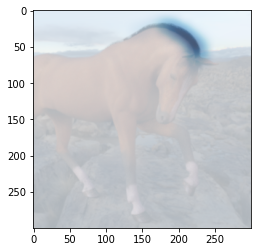

class_true: 1, class_pred: 1, likelihood: 0.5944667458534241


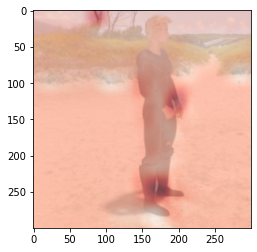

class_true: 1, class_pred: 1, likelihood: 0.6729070544242859


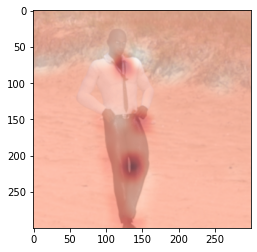

class_true: 0, class_pred: 1, likelihood: 0.5275147557258606


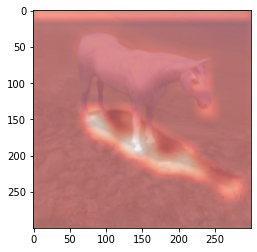

In [28]:
test_on_batch(single_batch_inputs, single_batch_labels, single_batch_features, single_batch_predictions)